In [112]:
import awkward as ak
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from codes.plotting import plot_prettier 
#plot_prettier()

In [113]:
data = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\ntup_tracks.json"))
data1 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\makeMuonPlots.json"))

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\leoro\\OneDrive\\Muon_Collider\\Psets\\mucol_plotting_scripts-main\\macros\\local_scripts\\ntup_tracks.json'

This error occurred while calling

    ak.from_json(
        source = WindowsPath-instance
        line_delimited = False
        schema = None
        nan_string = None
        posinf_string = None
        neginf_string = None
        complex_record_fields = None
        buffersize = 65536
        initial = 1024
        resize = 8
        highlevel = True
        behavior = None
    )

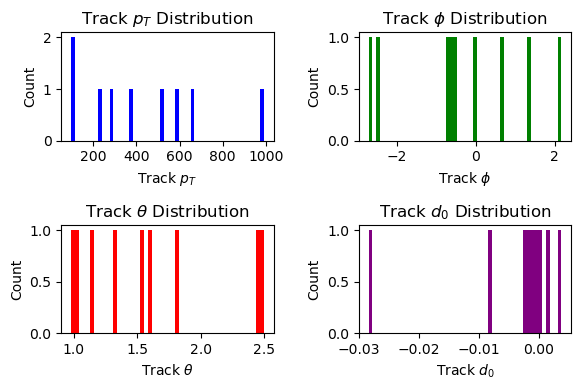

In [114]:
# Extract the required arrays from the data
track_pt = data['track_pt']
track_phi = data['track_phi']
track_theta = data['track_theta']
track_d0 = data['track_d0']
track_z0 = data['track_z0']
track_chi2 = data['track_chi2']
track_ndof = data['track_ndof']

# Create histograms
plt.figure(figsize=(6, 4))

# Histogram for track pt
plt.subplot(2, 2, 1)
plt.hist(ak.flatten(track_pt), bins=50, color='blue')
plt.xlabel('Track $p_T$')
plt.ylabel('Count')
plt.title('Track $p_T$ Distribution')

# Histogram for track phi
plt.subplot(2, 2, 2)
plt.hist(ak.flatten(track_phi), bins=50, color='green')
plt.xlabel('Track $\\phi$')
plt.ylabel('Count')
plt.title('Track $\\phi$ Distribution')

# Histogram for track theta
plt.subplot(2, 2, 3)
plt.hist(ak.flatten(track_theta), bins=50, color='red')
plt.xlabel('Track $\\theta$')
plt.ylabel('Count')
plt.title('Track $\\theta$ Distribution')

# Histogram for track d0
plt.subplot(2, 2, 4)
plt.hist(ak.flatten(track_d0), bins=50, color='purple')
plt.xlabel('Track $d_0$')
plt.ylabel('Count')
plt.title('Track $d_0$ Distribution')

# Adjust subplot spacing
plt.tight_layout()

# Display the histograms
plt.show()


In [115]:
data

<Record {truth_pt: [[525], ...], ...} type='{truth_pt: var * var * float64,...'>

In [116]:
data1

<Record {mcp_pt: [[198], ...], ...} type='{mcp_pt: var * var * float64, mcp...'>

In [117]:
mcp_pt = data1['mcp_pt']
mcp_eta = data1['mcp_eta']
mcp_phi = data1['mcp_phi']
pfo_pt = data1['pfo_pt']
pfo_eta = data1['pfo_eta']
pfo_phi = data1['pfo_phi']
pfo_mu_pt = data1['pfo_mu_pt']
pfo_mu_eta = data1['pfo_mu_eta']
pfo_mu_phi = data1['pfo_mu_phi']
mcp_mu_pt = data1['mcp_mu_pt']
mcp_mu_eta = data1['mcp_mu_eta']
mcp_mu_phi = data1['mcp_mu_phi']
mcp_mu_match_pt = data1['mcp_mu_match_pt']
mcp_mu_match_eta = data1['mcp_mu_match_eta']
mcp_mu_match_phi = data1['mcp_mu_match_phi']
d_mu_dpt = data1['d_mu_dpt']
d_mu_drelpt = data1['d_mu_drelpt']
d_mu_dphi = data1['d_mu_dphi']
d_mu_deta = data1['d_mu_deta']
nhits = data1['nhits']
pt_res_hits = data1['pt_res_hits']
pt_res_vs_eta = data1['pt_res_vs_eta']
pt_res_vs_pt = data1['pt_res_vs_pt']
d0_res_vs_pt = data1['d0_res_vs_pt']
d0_res_vs_eta = data1['d0_res_vs_eta']
z0_res_vs_pt = data1['z0_res_vs_pt']
z0_res_vs_eta = data1['z0_res_vs_eta']
d0_res = data1['d0_res']
z0_res = data1['z0_res']
pt_res = data1['pt_res'] 
pt_match = data1['pt_match']
eta_match = data1['eta_match']
d0_res_match = data1['d0_res_match']
z0_res_match = data1['z0_res_match']
h2d_relpt = data1['h_2d_relpt']

In [146]:
def fwhm(data, bins):
    bin_contents, bin_edges = np.histogram(data, bins=bins)
    max_bin_index = np.argmax(bin_contents)
    max_bin_content = bin_contents[max_bin_index]
    threshold = max_bin_content / 2.0
    left_boundary_index = max_bin_index
    right_boundary_index = max_bin_index
    # Move to the left until bin content falls below threshold
    while bin_contents[left_boundary_index] >= threshold:
        left_boundary_index -= 1
    # Move to the right until bin content falls below threshold
    while bin_contents[right_boundary_index] >= threshold:
        right_boundary_index += 1
    # Calculate FWHM
    fwhm = bin_edges[right_boundary_index + 1] - bin_edges[left_boundary_index]
    return fwhm

def plotrms(datax, datay, bins, label=""):
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T

    x_bins = np.linspace(data_flatx.min(), data_flatx.max(), bins + 1)
    rms_values = []
    
    for i in range(bins):
        x_bin_data = data_flaty[(data_flatx >= x_bins[i]) & (data_flatx < x_bins[i + 1])]
        counts, bin_edges = np.histogram(x_bin_data, bins=1000)  # You can adjust the number of bins for the 1D histogram here
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Fit a Gaussian to the 1D histogram
        try:
            popt, _ = curve_fit(lambda x, a, mu, sigma: a * np.exp(-0.5 * ((x - mu) / sigma)**2), bin_centers, counts)
            rms_values.append(popt[2])
        except RuntimeError:  # If the fit fails for a specific bin, add a NaN value for that bin
            rms_values.append(np.nan)

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)

    ax.scatter(x_bins[:-1], rms_values, color = 'darkblue', marker='o', s = 3, linestyle='-')
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]     
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2] 
    ax.set_title(title)
    ax.set_xlabel(xlabel)#, fontsize=8)
    ax.set_ylabel(ylabel)#, fontsize=8)
    plt.show()

# a handy plotting function
def plot2DHistogram(datax, datay, bins=100, norm="log", label="", xlim = None, ylim = None, stats = True):
    
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
    #print(len(data_flatx),data_flatx)
    #print(len(data_flaty),data_flaty)
    
    fig = plt.figure(figsize=(4.5,3))
    ax = fig.add_subplot(111)

    hh = ax.hist2d(data_flatx, data_flaty, bins=bins, norm=norm, cmap="viridis")
    
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2]  
    zlabel = "" if len(label.split(";")) < 4 else label.split(";")[3] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)#, fontsize=8)
    ax.set_ylabel(ylabel)#, fontsize=8)
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])

    if stats == True:
        # Calculate statistics
        num_entries = len(data_flatx)
        mean_x = np.mean(data_flatx)
        mean_y = np.mean(data_flaty)
        std_x = np.std(data_flatx)
        std_y = np.std(data_flaty)
        # Calculate FWHM of datay
        fwhm_value = fwhm(data_flaty, bins = np.linspace(np.min(data_flaty), np.max(data_flaty), bins[1]))
        
        # Create a text box to display statistics
        stats_text = 'FWHM '+ylabel+f':{fwhm_value:.3f}'#"Entries: {num_entries}\nMean x: {mean_x:.2f}\nMean y: {mean_y:.2f}\nStd Dev x: {std_x:.2f}\nStd Dev y: {std_y:.2f}"
        ax.text(0.5, 0.98, stats_text, transform=ax.transAxes, va='top', ha='left', bbox=dict(boxstyle='round, pad=0.5', facecolor='white', alpha=0.8), fontsize = 7)

    # colorbars are annoying
    cbar = fig.colorbar(hh[3])
    #cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.set_label(zlabel)#, fontsize=6)

    plt.show()

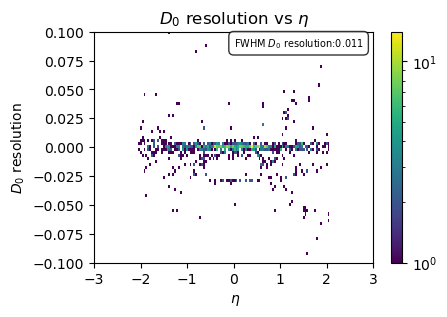

c:\Users\leoro\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
c:\Users\leoro\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


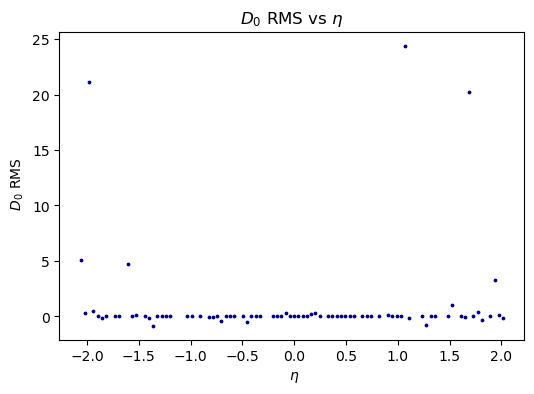

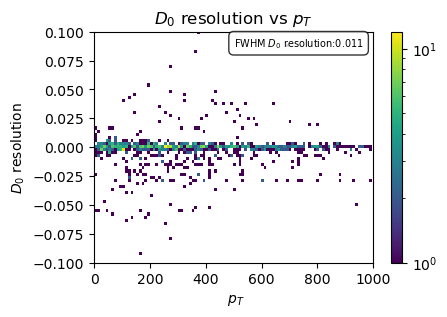

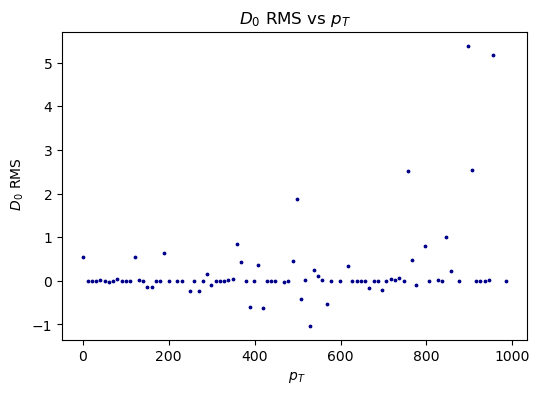

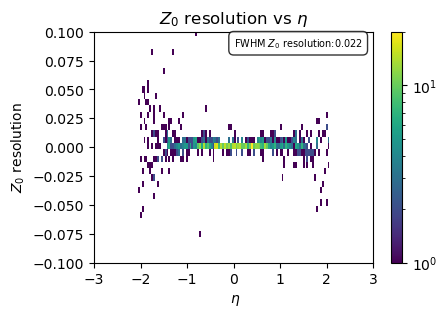

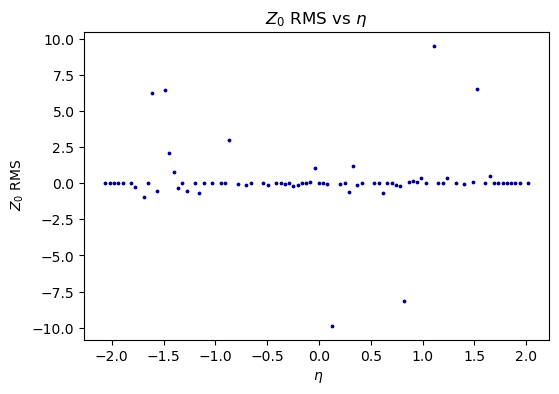

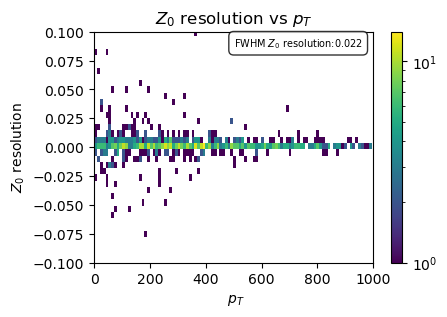

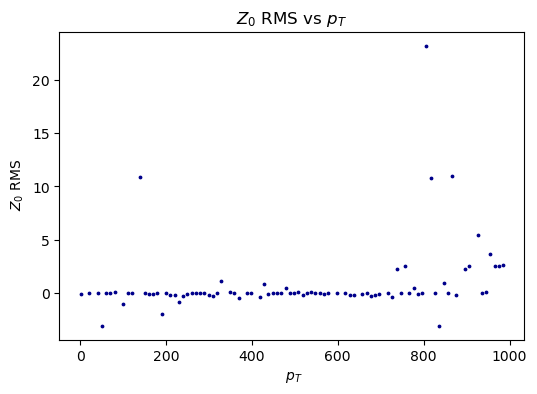

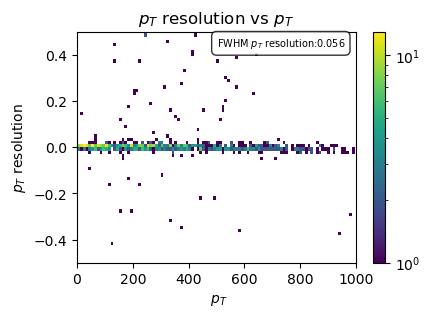

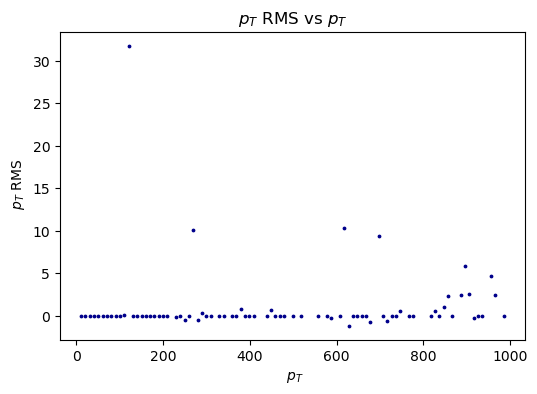

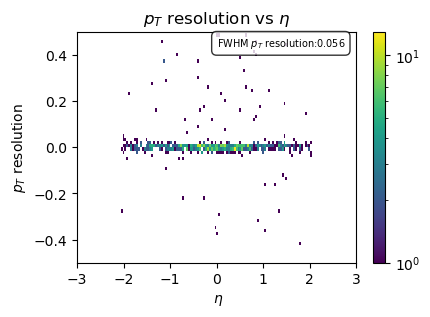

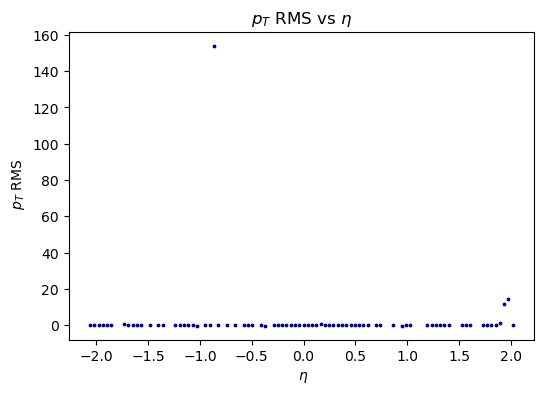

In [147]:
# # Histogram for mcp_eta
# plt.figure(figsize=(6, 3))

# plt.subplot(1, 2, 1)
# plt.hist((mcp_eta), bins=50, color='green')
# plt.xlabel('MCP $\\eta$')
# plt.ylabel('Count')
# plt.title('MCP $\\eta$ Distribution')

# # Histogram for mcp_phi
# plt.subplot(1, 2, 2)
# plt.hist((mcp_phi), bins=50, color='red')
# plt.xlabel('MCP $\\phi$')
# plt.ylabel('Count')
# plt.title('MCP $\\phi$ Distribution')

# # Adjust subplot spacing
# plt.tight_layout()


plot2DHistogram(eta_match, d0_res_match, bins=(100,600), label=r"$D_0$ resolution vs $\eta$; $\eta$;$D_0$ resolution", xlim = (-3,3), ylim = (-0.1,0.1))
plotrms(eta_match, d0_res_match, bins=100, label=r"$D_0$ RMS vs $\eta$; $\eta$; $D_0$ RMS")
plot2DHistogram(pt_match, d0_res_match, bins=(100,600), label=r"$D_0$ resolution vs $p_T$; $p_T$;$D_0$ resolution", xlim = (0,1000), ylim = (-0.1,0.1))
plotrms(pt_match, d0_res_match, bins=100, label=r"$D_0$ RMS vs $p_T$; $p_T$; $D_0$ RMS")
plot2DHistogram(eta_match, z0_res_match, bins=(100,1000), label=r"$Z_0$ resolution vs $\eta$; $\eta$;$Z_0$ resolution", xlim = (-3,3), ylim = (-0.1,0.1))
plotrms(eta_match, z0_res_match, bins=100, label=r"$Z_0$ RMS vs $\eta$; $\eta$; $Z_0$ RMS")
plot2DHistogram(pt_match, z0_res_match, bins=(100,1000), label=r"$Z_0$ resolution vs $p_T$; $p_T$;$Z_0$ resolution", xlim = (0,1000), ylim = (-0.1,0.1))
plotrms(pt_match, z0_res_match, bins=100, label=r"$Z_0$ RMS vs $p_T$; $p_T$; $Z_0$ RMS")
plot2DHistogram(pt_match, pt_res, bins=(100,10000), label=r"$p_T$ resolution vs $p_T$; $p_T$;$p_T$ resolution", xlim = (0,1000), ylim = (-0.5,0.5))
plotrms(pt_match, pt_res, bins=100, label=r"$p_T$ RMS vs $p_T$; $p_T$; $p_T$ RMS")
plot2DHistogram(eta_match, pt_res, bins=(100,10000), label=r"$p_T$ resolution vs $\eta$; $\eta$;$p_T$ resolution", xlim = (-3,3), ylim = (-0.5,0.5))
plotrms(eta_match, pt_res, bins=100, label=r"$p_T$ RMS vs $\eta$; $\eta$; $p_T$ RMS")


Text(0.5, 1.0, 'Track $p_T$ Resolution')

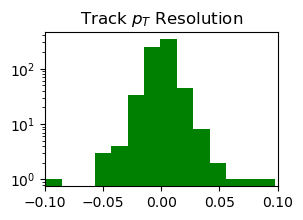

In [139]:
plt.figure(figsize=(3, 2))

plt.hist((np.ravel(pt_res)), bins=10000, color='green')
plt.yscale('log')
plt.xlim(-0.1,0.1)
plt.title('Track $p_T$ Resolution')

In [ ]:
for i in range(0,100):
    